## Imports

https://www.kaggle.com/mlg-ulb/creditcardfraud

In [70]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_curve, confusion_matrix, f1_score, accuracy_score, average_precision_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import precision_recall_curve, auc
from sklearn.metrics import plot_precision_recall_curve
from tqdm import tqdm
plt.style.use("seaborn")

In [4]:
records = pd.read_csv('creditcard.csv', delimiter=',', header=0)

# Check if data is well-formed

## Distribution of fraudulent vs. good transactions
Very few fraudulent records

In [5]:
records.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

## Normalize data

In [6]:
#Mean normalization
targets = records.pop('Class')
normalized_records=(records-records.mean())/records.std()
#normalized_records.hist(figsize=(20,20));

## Compare hists between classes

In [7]:
records0 = normalized_records[targets==0]
records1 = normalized_records[targets==1]
#records0.hist(figsize=(20,20));

In [8]:
#records1.hist(figsize=(20,20));

In [9]:
print("Differences between fraud and non-fraud:")
for i in records0.keys():
    print("Differences in",i)
    print("Median:", records0[i].median()-records1[i].median())
    print("Mean:", records0[i].mean()-records1[i].mean())
    print("Std:", records0[i].std()-records1[i].std())
    
    print()

Differences between fraud and non-fraud:
Differences in Time
Median: 0.19252172971223316
Mean: 0.2967350075315986
Std: -0.007398674870575661

Differences in V1
Median: 1.2061703137691455
Mean: 2.4405046304538205
Std: -2.4781146185470924

Differences in V2
Median: -1.6070883853499391
Mean: -2.198286258857717
Std: -1.6078579173914733

Differences in V3
Median: 3.4673686501116703
Mean: 4.64661415234859
Std: -3.727280862082994

Differences in V4
Median: -2.966060774701858
Mean: -3.2134966851943867
Std: -1.041046096449672

Differences in V5
Median: 1.0646680521499936
Mean: 2.2870389213706708
Std: -2.9092742802983906

Differences in V6
Median: 0.8643081611514458
Mean: 1.050953871019782
Std: -0.3964738063666099

Differences in V7
Median: 2.4861012371395548
Mean: 4.509252688613915
Std: -4.872679520684369

Differences in V8
Median: -0.5019178436083024
Mean: -0.4786050799310731
Std: -4.719331507786939

Differences in V9
Median: 1.9649929610563892
Mean: 2.3534625610834463
Std: -1.2848010599682733

In [10]:
top10 = ['V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18'] #Based on largest difference in median.
X = normalized_records[top10].to_numpy()
y = targets.to_numpy()

### Performance Metrics
The function below calculates a series of performance metrics.
1. Accuracy - This is the default metric and is not suited for this problem.
2. False negatives, False positives, True positives - Gives insight in how it classifies.
3. F1 score - Is considered suited for imbalanced datasets.
4. AUPRC - Area Under Precision-Recall Curve is the suggested metric from Kaggle.
5. AUC ROC - Area Under Curve Receiving Operating Characteristic is widely used for this specific task, but not good for imbalanced datasets
6. Average Precision - Should be a good overall measure for this task. 
7. Mean score for metrics - The mean for 3, 4, 5, 6

In [86]:
#True negatives are not printed due to it being the default classification.
def evaluate_model(model, name="", verbose=False):
    preds = model.predict(X_test)
    preds_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, preds_proba)
    fpr, tpr, _ = roc_curve(y_test, preds_proba)
    f1 = f1_score(preds, y_test)
    aucroc = auc(fpr, tpr)
    auprc = auc(recall, precision)
    avg_precision = average_precision_score(y_test, preds_proba)
    mean_score = np.mean([f1, auprc, aucroc, avg_precision])
    
    if verbose:
        cm = confusion_matrix(preds, y_test)
        tn, fp, fn, tp = cm.ravel()
        
        print("{} performance metrics:\n-=-=-=-=-=-".format(name))
        print("Raw accuracy (bad metric):", accuracy_score(preds, y_test))
        print("False negatives:", fn)
        print("False positives:", fp)
        print("True positives:", tp)
        print("F1 score:", f1)

        print("AUPRC:", auprc)
        print("AUC ROC:", aucroc)
        print("Average Precision Score:", avg_precision)
        print("Mean Score for Metrics:", mean_score)
        print()
    
    return [f1, auprc, aucroc, avg_precision, mean_score]

def print_scores(scores, name=""):
    print("{} performance metrics:\n-=-=-=-=-=-".format(name))
    print("F1 score:", scores[0])
    print("AUPRC:", scores[1])
    print("AUC ROC:", scores[2])
    print("Average Precision Score:", scores[3])
    print("Mean Score for Metrics:", scores[4])
    print()

## Evaluation
Using Stratified K-fold and the metrics above

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

skf = StratifiedKFold(n_splits=2, random_state=42)
lrg = LogisticRegression(n_jobs=4, random_state=42)
knn = KNeighborsClassifier(n_jobs=4)
rfc = RandomForestClassifier(n_estimators=300, n_jobs=4, random_state=42)
svc = SVC(probability=True, gamma=2, C=1, random_state=42)
nb = GaussianNB()
mlp = MLPClassifier(hidden_layer_sizes=[1000,200], random_state=42) #1000 500
dum = DummyClassifier(random_state=42)


lrg_accuracies = []
knn_accuracies = []
rfc_accuracies = []
#svc_accuracies = []
nb_accuracies = []
mlp_accuracies = []
dum_accuracies = []

for train_index, valid_index in tqdm(skf.split(X_train,y_train)):
    X_strat_train, X_valid = X[train_index], X[valid_index]
    y_strat_train, y_valid = y[train_index], y[valid_index]
    
    
    lrg.fit(X_strat_train, y_strat_train)
    dum.fit(X_strat_train, y_strat_train)
    knn.fit(X_strat_train, y_strat_train)
    rfc.fit(X_strat_train, y_strat_train)
    nb.fit(X_strat_train, y_strat_train)
    mlp.fit(X_strat_train, y_strat_train)
    
    lrg_accuracies.append(evaluate_model(lrg)) #Append the mean metrics
    dum_accuracies.append(evaluate_model(dum))
    knn_accuracies.append(evaluate_model(knn))
    rfc_accuracies.append(evaluate_model(rfc))
    nb_accuracies.append(evaluate_model(nb))
    mlp_accuracies.append(evaluate_model(mlp))
    #break #Only do it once for speed purpose when experimenting

print_scores(np.mean(dum_accuracies, axis=0), name="Baseline")
print_scores(np.mean(lrg_accuracies, axis=0), name="Logistic Regression")
print_scores(np.mean(knn_accuracies, axis=0), name="K-Nearest neighbours")
print_scores(np.mean(rfc_accuracies, axis=0), name="Random Forest")
print_scores(np.mean(nb_accuracies, axis=0), name="Naive Bayes")
print_scores(np.mean(mlp_accuracies, axis=0), name="Multilayer Perceptron")

c:\python37\lib\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
0it [00:00, ?it/s]c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
1it [10:37, 637.42s/it]c:\python37\lib\site-packages\sklearn\dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)
2it [19:49, 594.85s/it]

 performance metrics:
-=-=-=-=-=-
F1 score: 0.008249822856564431
AUPRC: 0.009135707181127254
AUC ROC: 0.5033837244324689
Average Precision Score: 0.0016983577891979342
Mean Score for Metrics: 0.13061690306483964

 performance metrics:
-=-=-=-=-=-
F1 score: 0.6529411764705881
AUPRC: 0.6739739036424538
AUC ROC: 0.9657323692774209
Average Precision Score: 0.6753467305403906
Mean Score for Metrics: 0.7419985449827133

 performance metrics:
-=-=-=-=-=-
F1 score: 0.7654396003173156
AUPRC: 0.8122666287515143
AUC ROC: 0.9399127023203833
Average Precision Score: 0.72763044896606
Mean Score for Metrics: 0.8113123450888182

 performance metrics:
-=-=-=-=-=-
F1 score: 0.856036767931041
AUPRC: 0.8055525300672985
AUC ROC: 0.9594932394046132
Average Precision Score: 0.7955633418675461
Mean Score for Metrics: 0.8541614698176248

 performance metrics:
-=-=-=-=-=-
F1 score: 0.2348585817794397
AUPRC: 0.5215317501836605
AUC ROC: 0.962686118520683
Average Precision Score: 0.26685311537384243
Mean Score for

In [83]:
evaluate_model(dum, name='Dummy Classifier', verbose=True)
evaluate_model(lrg, name="Logistic Regression", verbose=True)
evaluate_model(knn, name='K-Nearest Neighbours', verbose=True)
evaluate_model(rfc, name="Random Forest", verbose=True)
evaluate_model(nb, name="Naive Bayes", verbose=True)
evaluate_model(mlp, name="Multilayer Perceptron", verbose=True)

Dummy Classifier performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9967978427572259
False negatives: 105
False positives: 123
True positives: 0
F1 score: 0.0
AUPRC: 0.0008637397825903767
AUC ROC: 0.49926138521926305
Average Precision Score: 0.0017274795651807534
Mean Score for Metrics: 0.12546315114175854

Logistic Regression performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9992977725344794
False negatives: 15
False positives: 35
True positives: 88
F1 score: 0.7787610619469026
AUPRC: 0.7229168385755848
AUC ROC: 0.9745512750784452
Average Precision Score: 0.7239642327661315
Mean Score for Metrics: 0.8000483520917661

K-Nearest Neighbours performance metrics:
-=-=-=-=-=-
Raw accuracy (bad metric): 0.9993820398303418
False negatives: 15
False positives: 29
True positives: 94
F1 score: 0.8103448275862069
AUPRC: 0.8256226947142734
AUC ROC: 0.9469365187046545
Average Precision Score: 0.7355438769124685
Mean Score for Metrics: 0.8296119794794008

Random Forest perform

[0.8205128205128206,
 0.6983930289819938,
 0.9697254297491273,
 0.6997248026045866,
 0.797089020462132]

In [15]:
def plot_roc_cur(fper, tper, label="", title="plot title"):
    plt.plot(fper, tper, label=label)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    
def create_roc_curve(preds, targets, label="", title=""):
    all_fpr, all_tpr = [], []
    fpr, tpr, thresholds = roc_curve(targets, preds)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_fpr = np.array(all_fpr)
    all_tpr = np.array(tpr)
    
    plot_roc_cur(all_fpr[0], all_tpr, label=label, title=title)

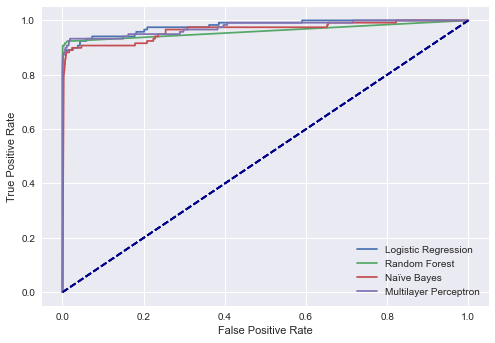

In [16]:
create_roc_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
#create_roc_curve(svc.predict_proba(X_test)[:,1], y_test, label="Support Vector Classifier")
create_roc_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_roc_curve(nb.predict_proba(X_test)[:,1], y_test, label="Naïve Bayes")
create_roc_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")

## Precicion Recall Curve

In [84]:
def plot_pr_cur(p, r, label="", title="plot title"):
    plt.plot(r, p, label=label)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    
def create_pr_curve(preds, targets, label="", title=""):
    all_p, all_r = [], []
    p, r, thresholds = precision_recall_curve(targets, preds)
    all_p.append(p)
    all_r.append(r)
    all_p = np.array(p)
    all_r = np.array(r)
    
    plot_pr_cur(all_p, all_r, label=label, title=title)

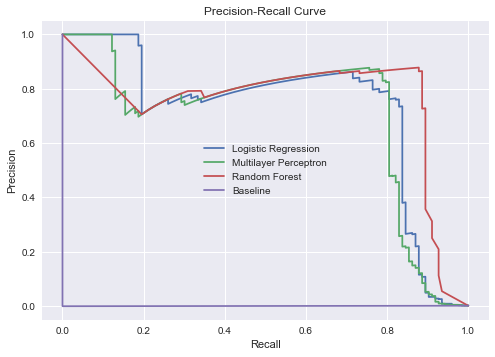

In [85]:
create_pr_curve(lrg.predict_proba(X_test)[:,1], y_test, label="Logistic Regression")
create_pr_curve(mlp.predict_proba(X_test)[:,1], y_test, label="Multilayer Perceptron")
create_pr_curve(rfc.predict_proba(X_test)[:,1], y_test, label="Random Forest")
create_pr_curve(dum.predict_proba(X_test)[:,1], y_test, label="Baseline", title="Precision-Recall Curve")

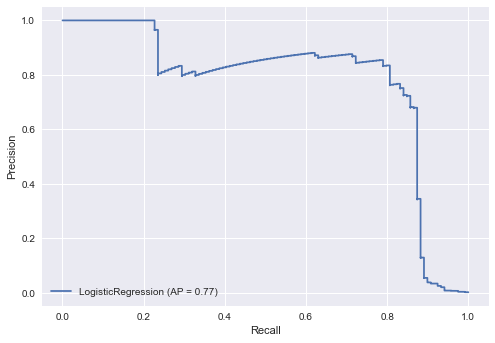

In [49]:
plot_precision_recall_curve(lrg, X_test, y_test)

In [89]:
l = [[1,2,3], [1,2,3]]
np.mean(l, axis=0)

array([1., 2., 3.])